In [1]:
# Load and clean data
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Read the file
column_names = ['sequence_name', 'tag_identificator', 'timestamp', 'date', 'x-coordinate', 'y-coordinate', 'z-coordinate', 'activity']
data_act = pd.read_csv('ConfLongDemo_JSI.txt',sep=',',header=None, names=column_names)

# Makes the data easier to understand. Replace name of tag_idintificator
data_act = data_act.replace(to_replace= '010-000-024-033', value='ankle_left')
data_act = data_act.replace(to_replace= '010-000-030-096', value='ankle_right')
data_act = data_act.replace(to_replace= '020-000-033-111', value='chest')
data_act = data_act.replace(to_replace= '020-000-032-221', value='belt')

# Convert date to a pandas datetime object 
data_act['date'] = pd.to_datetime(data_act['date'], format='%d.%m.%Y %H:%M:%S:%f')


In [2]:
# Split data into 4 different models based on tag
data_act_belt = data_act[data_act['tag_identificator'].isin(['belt'])]
data_act_chest = data_act[data_act['tag_identificator'].isin(['chest'])]
data_act_anrig = data_act[data_act['tag_identificator'].isin(['ankle_right'])]
data_act_anlef = data_act[data_act['tag_identificator'].isin(['ankle_left'])]

In [3]:
# We split the data using whole groups of sequences (A01+A02+---A05, B01+....+B05 etc).
# The next two lines were used to single out a sequence
random.seed(55)
print(random.randint(1, 5))
# The number one correlates with the letter A.
data_act['sequence_name'].unique()


NameError: name 'random' is not defined

In [4]:
# Split into training and test set

from sklearn.model_selection import train_test_split
import numpy as np
import random

# We split our data based on the results from the cell above. All A01-A05 sequences are selected. 
# Roughly 20% of our data.
train_data_act_chest = data_act_chest[data_act_chest['sequence_name'].isin(['B01', 'B02', 'B03', 'B04',
       'B05', 'C01', 'C02', 'C03', 'C04', 'C05', 'D01', 'D02', 'D03',
       'D04', 'D05', 'E01', 'E02', 'E03', 'E04', 'E05'])]
test_data_act_chest = data_act_chest[data_act_chest['sequence_name'].isin(['A01', 'A02', 'A03', 'A04', 'A05'])]





y_chest_train = train_data_act_chest['activity'] 
X_chest_train = train_data_act_chest # Note that this still contains activity and such is really the whole train data frame, not just the X part

y_chest_test = test_data_act_chest['activity'] 
X_chest_test = test_data_act_chest # Note that this still contains activity and such is really the whole test data frame, not just the X part


# X_chest_train = X_chest_train[~X_chest_train.sequence_name.str.contains('|'.join(['B']))] # https://www.geeksforgeeks.org/how-to-drop-rows-that-contain-a-specific-string-in-pandas/



'display(y_chest_train)\ndisplay(X_chest_train)\ndisplay(y_chest_test)\ndisplay(X_chest_test)'

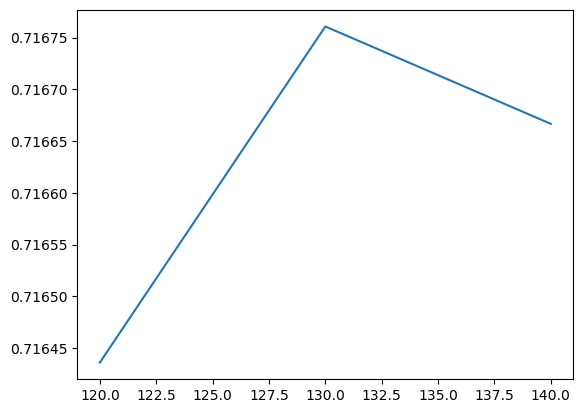

 Best K is:  130  has value:  0.7167606926719783


In [9]:
# Selecting parameters using cross validation
# Each function takes training, traines and testes and presents the accuracy. If we can feed it 
# If it can take the whole training set AND the sequences that should be used for test that would be great.
# It should return a print.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


def accuracy_tester(training_data_frame, list_of_validation_sequences, k_value):
    '''Test accuracy for one validation sequence (A1-5 etc) and one k value. Returns an accuracy number.'''
    # Duplicate data frame
    #training_data_frame = training_data_frame_in.copy(deep=True)
    # We split the data with test and training. 
    train_data_act_chest = training_data_frame[training_data_frame['sequence_name'].isin(list_of_validation_sequences)]
    test_data_act_chest = training_data_frame[~training_data_frame.sequence_name.str.contains('|'.join(list_of_validation_sequences))]
    
    y_chest_train = train_data_act_chest['activity'] 
    X_chest_train = train_data_act_chest

    y_chest_test = test_data_act_chest['activity'] 
    X_chest_test = test_data_act_chest


    # Drop unnecessary data for X
    column_list = ['sequence_name', 'tag_identificator', 'timestamp', 'date', 'activity']
    for element in column_list:
        X_chest_train = X_chest_train.drop(element, axis=1)
        X_chest_test = X_chest_test.drop(element, axis=1) # This is where we drop the labels (activity)
        
    # fit model
    knn = KNeighborsClassifier(n_neighbors=k_value)
    knn.fit(X_chest_train, y_chest_train)
    
    # Return accuracy
    predictions_generalization = knn.predict(X_chest_test)

    
    return accuracy_score(y_chest_test, predictions_generalization)


def accuracy_grapher_one_fold(X_chest_train, fold_list):
    '''Takes a data frame and a sequence and returns a graph '''
    list_of_accuracies = []
    k_values_to_test = np.arange(1, 3, 1).tolist()
    for k_value in k_values_to_test:
        list_of_accuracies.append(accuracy_tester(X_chest_train, fold_list, k_value))
    max_value = max(list_of_accuracies)
    plt.plot(k_values_to_test, list_of_accuracies)
    
    plt.title(fold_list[0])
    plt.show()
    print(list_of_accuracies)
    print(fold_list[1], ' Best K is: ', k_values_to_test[list_of_accuracies.index(max_value)], ' has value: ', max_value)
    
    return list_of_accuracies

def plot_all_folds(X_chest_train):
    accuracy_grapher_one_fold(X_chest_train, ['B01', 'B02', 'B03', 'B04', 'B05'])
    accuracy_grapher_one_fold(X_chest_train, ['C01', 'C02', 'C03', 'C04', 'C05'])
    accuracy_grapher_one_fold(X_chest_train, ['D01', 'D02', 'D03', 'D04', 'D05'])
    accuracy_grapher_one_fold(X_chest_train, ['E01', 'E02', 'E03', 'E04', 'E05'])
    
    
# Code Below is used to calculate the best accuracy by weighing all 4 together    

def accuracy_calculator(X_chest_train, fold_list, k_values_to_test):
    '''Takes a data frame and a sequence and returns a graph '''
    list_of_accuracies = []
    
    for k_value in k_values_to_test:
        list_of_accuracies.append(accuracy_tester(X_chest_train, fold_list, k_value))
    return list_of_accuracies
 
def find_best_k_value(X_chest_train):
    k_values_to_test = np.arange(120, 150, 10).tolist()
    list_w_accuracies = []
    list_w_accuracies.append(np.array(accuracy_calculator(X_chest_train, ['B01', 'B02', 'B03', 'B04', 'B05'], k_values_to_test)))
    list_w_accuracies.append(np.array(accuracy_calculator(X_chest_train, ['C01', 'C02', 'C03', 'C04', 'C05'], k_values_to_test)))
    list_w_accuracies.append(np.array(accuracy_calculator(X_chest_train, ['D01', 'D02', 'D03', 'D04', 'D05'], k_values_to_test)))
    list_w_accuracies.append(np.array(accuracy_calculator(X_chest_train, ['E01', 'E02', 'E03', 'E04', 'E05'], k_values_to_test)))
    # The line below adds the accuracies together and finds the average of that
    weighed_together_accuracies = (list_w_accuracies[0] + list_w_accuracies[1] + list_w_accuracies[2] + list_w_accuracies[3]) / 4
    list_of_weighed_values = weighed_together_accuracies.tolist()
    max_value = max(list_of_weighed_values)
    plt.plot(k_values_to_test, list_of_weighed_values)
    
    plt.show()
    print(' Best K is: ', k_values_to_test[list_of_weighed_values.index(max_value)], ' has value: ', max_value)
    
    
find_best_k_value(X_chest_train)

In [5]:
# Fit model
from sklearn.neighbors import KNeighborsClassifier

# We drop unwanted columns from X
column_list = ['sequence_name', 'tag_identificator', 'timestamp', 'date', 'activity']
for element in column_list:
    X_chest_train = X_chest_train.drop(element, axis=1)
    X_chest_test = X_chest_test.drop(element, axis=1) # This is where we drop the labels (activity)


# We fit the model
knn = KNeighborsClassifier(n_neighbors=130)
knn.fit(X_chest_train, y_chest_train)


KNeighborsClassifier(n_neighbors=130)

/Users/alakazam/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/alakazam/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

                                        precision    recall  f1-score   support

                               falling       1.00      0.08      0.14       129
                                 lying       0.87      0.94      0.90      2939
                            lying down       0.09      0.01      0.02       224
                          on all fours       0.56      0.49      0.52       309
                               sitting       0.80      0.89      0.84      1380
                          sitting down       0.33      0.03      0.05        69
                 sitting on the ground       0.77      0.94      0.85       665
                standing up from lying       0.55      0.49      0.51       683
              standing up from sitting       0.00      0.00      0.00        41
standing up from sitting on the ground       0.42      0.11      0.18       133
                               walking       0.76      0.84      0.80       994

                              accuracy

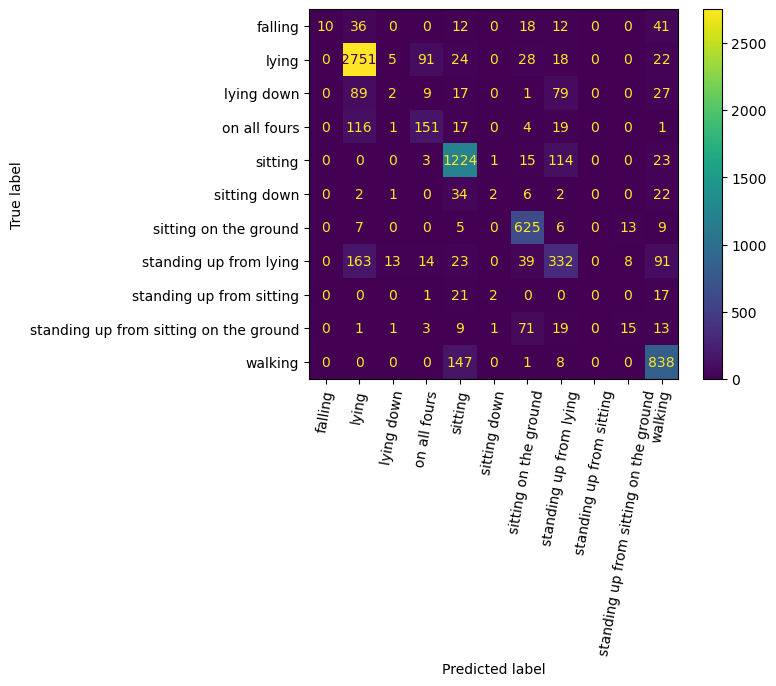

"sns.heatmap(confusion, annot=True, fmt='g')\nplt.set_xticklabels([''] + knn.classes_)\nplt.title('Confusion Matrix')\nplt.xlabel('Predicted activity')\nplt.ylabel('True activity')\nplt.show()"

In [16]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report


# Evluation
predictions = knn.predict(X_chest_test) # This is where we calculate our prediction

# We create a confusion table, print the classification report and plot the confusion matrix
confusion = confusion_matrix(y_chest_test, predictions, labels=knn.classes_)
print(classification_report(y_chest_test, knn.predict(X_chest_test)))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=knn.classes_)
disp.plot()
plt.xticks(rotation=80)
plt.show()